In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # great plotting library
from pathlib import Path
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from natsort import natsorted
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [3]:
# Load the data, modify these paths to your own
datapath = r"D:\Downloads\241108_N2_RTK_library_forHarrison.xlsx"
savepath = Path(r"D:\Tracking\NucleiTracking\figures\beena")
df = pd.read_excel(datapath)

# remove the rows with four or more motifs (ladder)
df = df[df["Motif 4"].isna()]
df = df.reset_index()

# print out the columns
print(df.columns)

Index(['index', 'RTK ID', 'Beena Migration? ', 'Motif 1', 'Motif 2', 'Motif 3',
       'Motif 4', 'Motif 5', 'Motif 6', 'Motif 7', 'Motif 8', 'delta_FinFout',
       'pPF050 delta_Finout', 'pBL47_delta_Finout', 'Quant Exp ID'],
      dtype='object')


In [4]:


"""
Convert the data into vectors representing the presence of motifs
"""
all_motifs = set()

for i in range(1, 9):
    col = f"Motif {i}"
    all_motifs.update(df[col].unique())
    
all_motifs.remove(np.nan)

motifs = natsorted((all_motifs))

motif_index = {motif: i for i, motif in enumerate(motifs)}

# create a vector for each rtk
rtk_vectors = []
for i, row in df.iterrows():
    rtk_vector = np.zeros(len(all_motifs))
    for j in range(1, 9):
        motif = row[f"Motif {j}"]
        if pd.isna(motif):
            continue
        rtk_vector[motif_index[motif]] += 1
    rtk_vectors.append(rtk_vector)

"""
X_all[i, j] is the number of times motif j is present in RTK i
"""
X_all = np.array(rtk_vectors)
print(f"X_all: {X_all.shape}")

"""
determining pairwise motifs
"""
r_x_all = np.expand_dims(X_all, -1) > 0
pairwise_x_all = np.matmul(r_x_all, r_x_all.transpose((0, 2, 1)))
# pairwise_x_all.shape = (n_rtk, n_motifs, n_motifs)

"""
unwrapping each 9x9 matrix into a vector of the diagonal and upper triangular part (45 entries)
"""
# ids converts from flattened coordinates into matrix coordinates: ids[0][i] = motif 1, ids[1][i] = motif 2
ids = (np.triu_indices(pairwise_x_all.shape[1], k=0))
flattened_ids = ids[0] * pairwise_x_all.shape[1] + ids[1]
pairwise_x_all = np.reshape(pairwise_x_all, (pairwise_x_all.shape[0], -1))[:, flattened_ids]
print(f"pairwise_x_all: {pairwise_x_all.shape}")

# reverse index allows us to convert from flattened coordinates to motif pairs
reverse_index = {i: [motifs[ids[0][i]], motifs[ids[1][i]]] for i in range(len(flattened_ids))}
print(reverse_index)

"""
Target variable: migration direction
"""
Y_all = df["Beena Migration? "].values
print(f"Y_all: {Y_all.shape}")

X_all: (138, 9)
pairwise_x_all: (138, 45)
{0: ['Grb2', 'Grb2'], 1: ['Grb2', 'Nck/PI3K'], 2: ['Grb2', 'PI3K'], 3: ['Grb2', 'PLCy'], 4: ['Grb2', 'SHP2'], 5: ['Grb2', 'STAT3'], 6: ['Grb2', 'STAT5'], 7: ['Grb2', 'Shc'], 8: ['Grb2', 'Src'], 9: ['Nck/PI3K', 'Nck/PI3K'], 10: ['Nck/PI3K', 'PI3K'], 11: ['Nck/PI3K', 'PLCy'], 12: ['Nck/PI3K', 'SHP2'], 13: ['Nck/PI3K', 'STAT3'], 14: ['Nck/PI3K', 'STAT5'], 15: ['Nck/PI3K', 'Shc'], 16: ['Nck/PI3K', 'Src'], 17: ['PI3K', 'PI3K'], 18: ['PI3K', 'PLCy'], 19: ['PI3K', 'SHP2'], 20: ['PI3K', 'STAT3'], 21: ['PI3K', 'STAT5'], 22: ['PI3K', 'Shc'], 23: ['PI3K', 'Src'], 24: ['PLCy', 'PLCy'], 25: ['PLCy', 'SHP2'], 26: ['PLCy', 'STAT3'], 27: ['PLCy', 'STAT5'], 28: ['PLCy', 'Shc'], 29: ['PLCy', 'Src'], 30: ['SHP2', 'SHP2'], 31: ['SHP2', 'STAT3'], 32: ['SHP2', 'STAT5'], 33: ['SHP2', 'Shc'], 34: ['SHP2', 'Src'], 35: ['STAT3', 'STAT3'], 36: ['STAT3', 'STAT5'], 37: ['STAT3', 'Shc'], 38: ['STAT3', 'Src'], 39: ['STAT5', 'STAT5'], 40: ['STAT5', 'Shc'], 41: ['STAT5', 'Src'

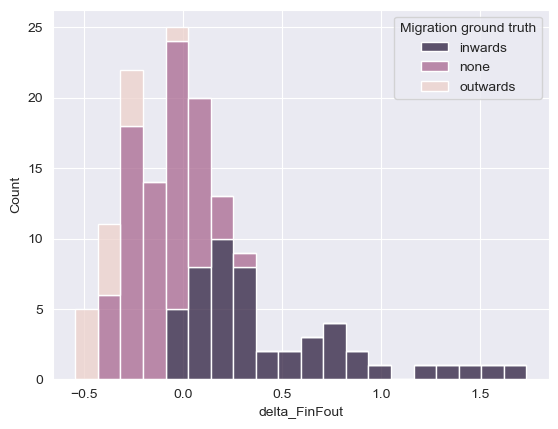

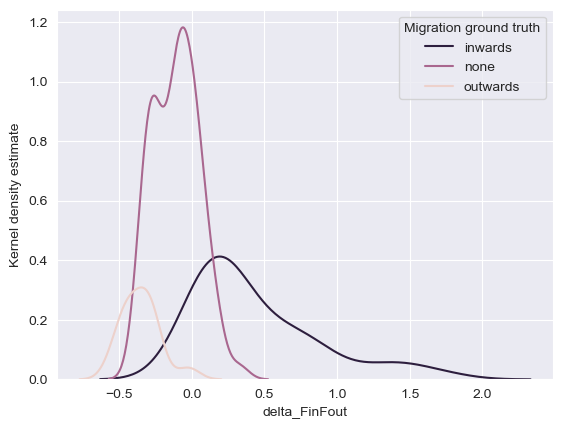

In [5]:
"""
Replating delta_FinFout with migration direction
"""

sns.histplot(df, x="delta_FinFout", hue="Beena Migration? ", bins=20, multiple="stack")
plt.legend(title="Migration ground truth", labels=["inwards", "none", "outwards"])
plt.savefig(savepath / "delta_FinFout.png")
plt.show()

sns.kdeplot(df, x="delta_FinFout", hue="Beena Migration? ")
plt.legend(title="Migration ground truth", labels=["inwards", "none", "outwards"])
plt.ylabel("Kernel density estimate")
plt.savefig(savepath / "delta_FinFout_kde.png")
plt.show()

RangeIndex(start=0, stop=138, step=1)


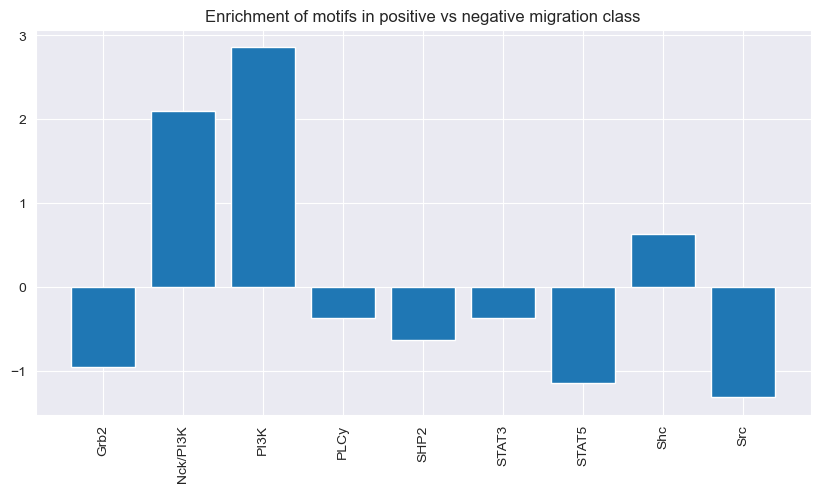

In [6]:
# enrichment analysis

# get the motifs that are enriched in the positive migration class
positive_migration = df[df["Beena Migration? "] == 1]
negative_migration = df[df["Beena Migration? "] == -1]

print(df.index)

positive_migration_counts = np.sum([rtk_vectors[i] for i in positive_migration.index], axis=0)
negative_migration_counts = np.sum([rtk_vectors[i] for i in negative_migration.index], axis=0)

positive_migration_counts = positive_migration_counts / np.sum(positive_migration_counts)
negative_migration_counts = negative_migration_counts / np.sum(negative_migration_counts)

enrichment = np.log2(positive_migration_counts / negative_migration_counts)
plt.figure(figsize=(10, 5))
plt.bar(motifs, enrichment)
plt.title("Enrichment of motifs in positive vs negative migration class")
plt.xticks(rotation=90)
plt.savefig(savepath / "enrichment.png")
plt.show()

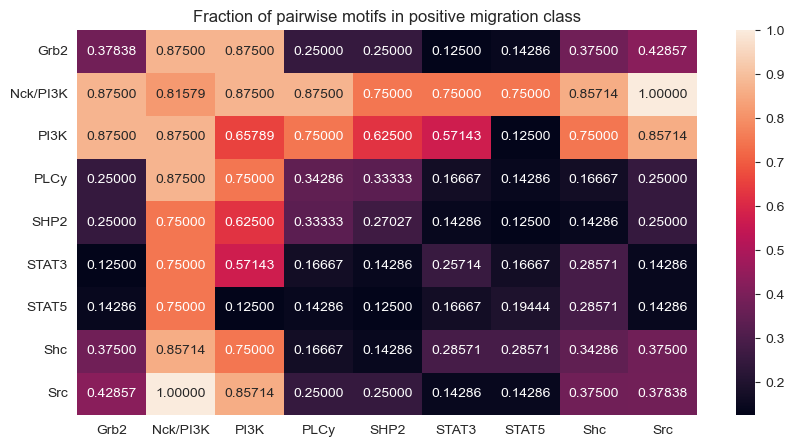

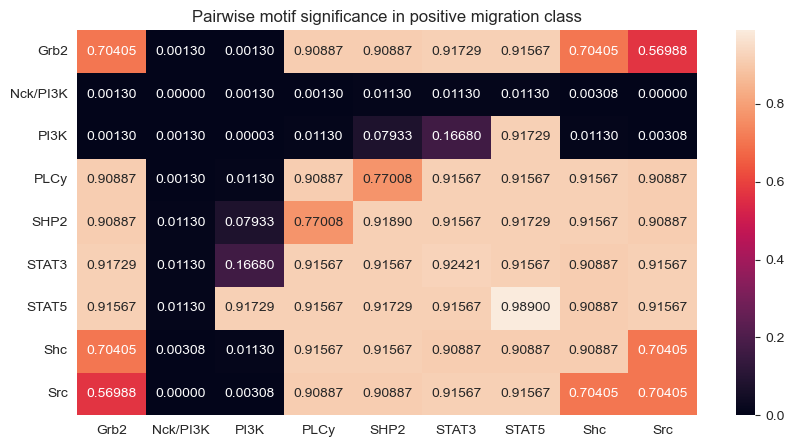

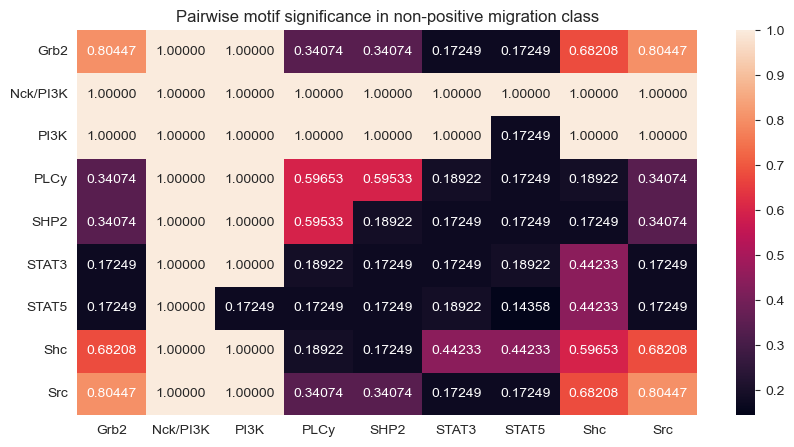

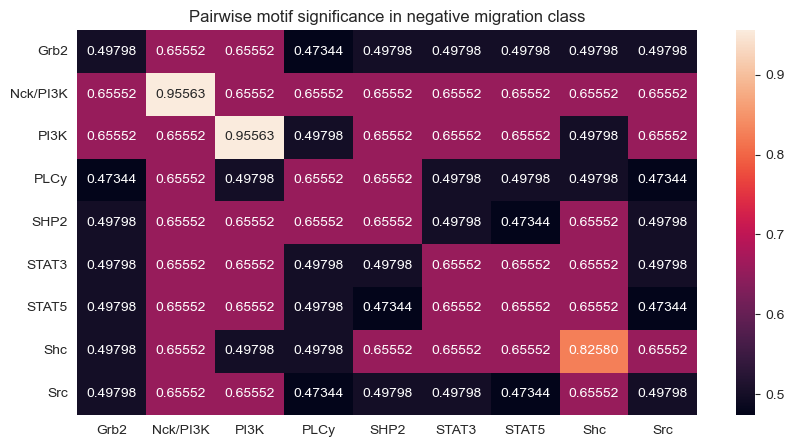

In [12]:
def heatmap(s):
    plt.figure(figsize=(10, 5))
    hm = np.zeros((len(motifs), len(motifs)))
    for i, (xi, yi) in enumerate(zip(ids[0], ids[1])):
        hm[xi, yi] = s[i]
        hm[yi, xi] = s[i]
    sns.heatmap(hm, xticklabels=motifs, yticklabels=motifs, annot=True, fmt=".5f")

"""
Get the motifs present in the positive and negative migration classes
"""
pairwise_pos = pairwise_x_all[Y_all > 0]
pairwise_neg = pairwise_x_all[Y_all < 0]

"""
plot for each pairwise motif the fraction of positive migration class that has it
"""
pairwise_pos_counts = np.sum(pairwise_pos, axis=0)
pairwise_pos_frac= pairwise_pos_counts / np.sum(pairwise_x_all, axis=0)
heatmap(pairwise_pos_frac)
plt.title("Fraction of pairwise motifs in positive migration class")
plt.savefig(savepath / "pairwise_pos_frac.png")
plt.show()


"""
Determine significance of enrichment in positive migration class using hypergeometric test
https://montilab.github.io/BS831/articles/docs/HyperEnrichment.html
"""

signficances = []
for i in range(len(ids[0])):
    N = len(pairwise_x_all)   # total number of RTKs
    n = np.sum(pairwise_x_all[:, i])    # total number of RTKs with motif i
    K = len(pairwise_pos)     # total number of RTKs in positive migration class
    k = np.sum(pairwise_pos[:, i])      # total number of RTKs in positive migration class with motif i
    p = hypergeom.sf(k, N, n, K)
    signficances.append(p)
    
s = np.array(signficances)

# use Benjamini-Hochberg correction
# technically not valid because the tests are not independent
# but we can use it as a heuristic
# https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini%E2%80%93Hochberg_procedure
s = multipletests(s, method="fdr_bh")[1]
    
heatmap(s)
plt.title("Pairwise motif significance in positive migration class")
plt.savefig(savepath / "pairwise_pos_significance.png")
plt.show()


"""
Determine signficiance of non-enrichment in positive migration class using hypergeometric test
"""

signficances = []
for i in range(len(ids[0])):
    N = len(pairwise_x_all)
    n = np.sum(pairwise_x_all[:, i])
    K = N - len(pairwise_pos)
    k = n - np.sum(pairwise_pos[:, i])
    p = hypergeom.sf(k, N, n, K)
    signficances.append(p)
    
s = np.array(signficances)
s = multipletests(s, method="fdr_bh")[1]
    
heatmap(s)
plt.title("Pairwise motif significance in non-positive migration class")

plt.savefig(savepath / "pairwise_nonpos_significance.png")
plt.show()

"""
Determine signficiance of enrichment in negative migration class
"""
signficances = []
for i in range(len(ids[0])):
    N = len(pairwise_x_all)
    n = np.sum(pairwise_x_all[:, i])
    K = len(pairwise_neg)
    k = np.sum(pairwise_neg[:, i])
    p = hypergeom.sf(k, N, n, K)
    signficances.append(p)
    
s = np.array(signficances)
s = multipletests(s, method="fdr_bh")[1]
    
heatmap(s)
plt.title("Pairwise motif significance in negative migration class")

plt.savefig(savepath / "pairwise_neg_significance.png")
plt.show()

# Logistic regression

Baseline expectation: 0.6376811594202898
Train score: 0.9090909090909091
Test score: 0.8214285714285714
(1, 45)
[-3.77884712]


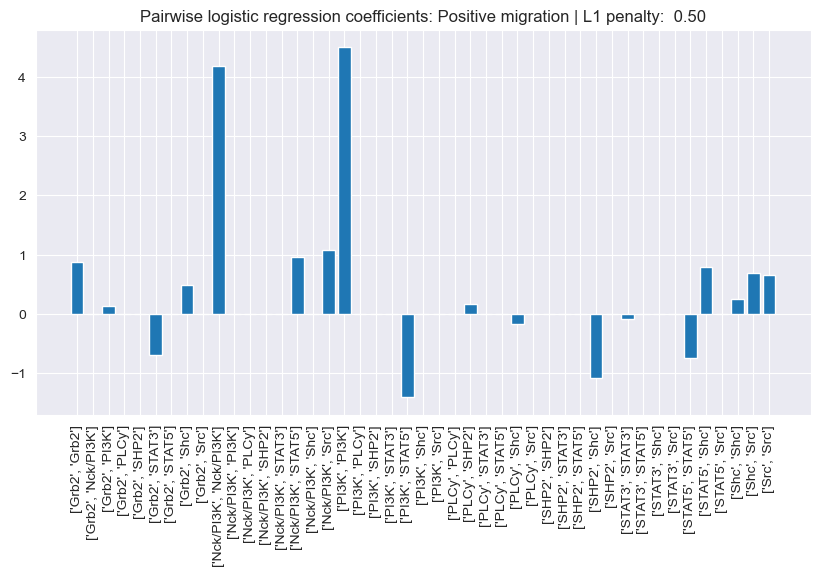

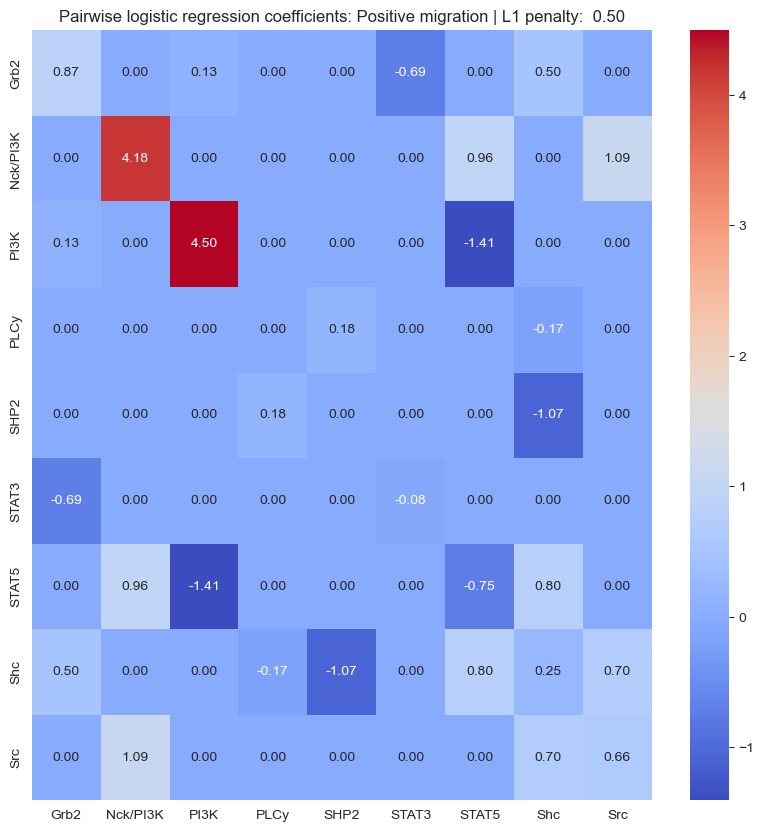

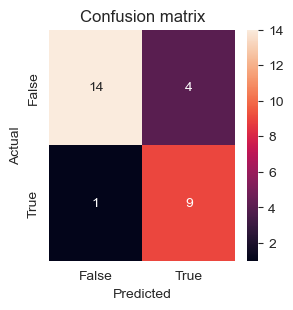

In [14]:
# logistic regression

# can modify this to change the penalty, higher number = less regularization
l1pen = 2

X_train, X_test, Y_train, Y_test = train_test_split(pairwise_x_all, Y_all, test_size=0.2)

positive_migration_model = LogisticRegression(penalty="l1", solver="liblinear", C=l1pen)
positive_migration_model.fit(X_train, Y_train > 0)

print(f"Baseline expectation: {1 - np.mean(Y_all > 0)}")
print(f"Train score: {positive_migration_model.score(X_train, Y_train > 0)}")
print(f"Test score: {positive_migration_model.score(X_test, Y_test > 0)}")

print(positive_migration_model.coef_.shape)
print(positive_migration_model.intercept_)

# show the coefficients
plt.figure(figsize=(10, 5))
plt.bar([str(k) for k in reverse_index.values()], positive_migration_model.coef_[0])
plt.title(f"Pairwise logistic regression coefficients: Positive migration | L1 penalty: {1/l1pen: .2f}")
plt.xticks(rotation=90)
plt.savefig(savepath / f"pairwise_positive_migration_l1_{l1pen}_bars.png")
plt.show()

# show as heatmap
x = ids[0]
y = ids[1]
z = positive_migration_model.coef_[0]
plt.figure(figsize=(10, 10))
hm = np.zeros((len(motifs), len(motifs)))
for i, (xi, yi) in enumerate(zip(x, y)):
    hm[xi, yi] = z[i]
    hm[yi, xi] = z[i]
sns.heatmap(hm, xticklabels=motifs, yticklabels=motifs, annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Pairwise logistic regression coefficients: Positive migration | L1 penalty: {1/l1pen: .2f}")
plt.savefig(savepath / f"heatmap_positive_migration_l1_{l1pen}.png")
plt.show()


y_pred = positive_migration_model.predict(X_test)

# plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(pd.crosstab(Y_test > 0, y_pred > 0), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()

Baseline expectation: 0.6376811594202898
Train score: 0.8636363636363636
Test score: 0.8214285714285714
(1, 9)
[-2.0027421]


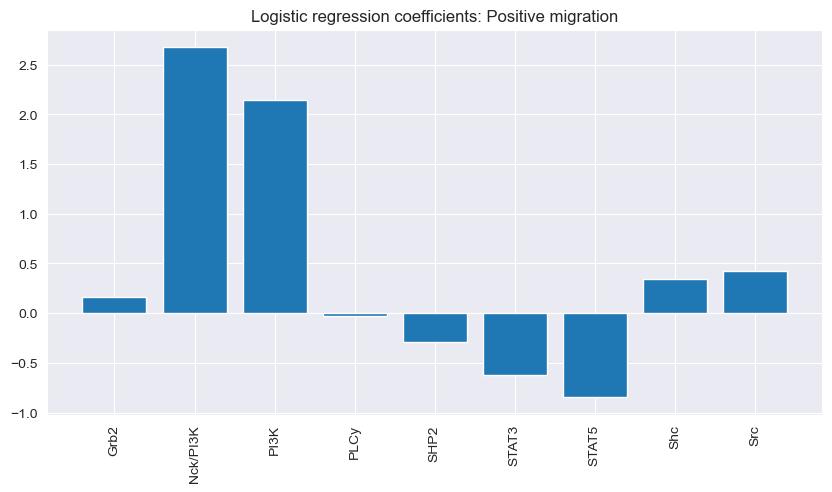

RTK10
Actual: False, Predicted: True
PI3K Shc

RTK123
Actual: True, Predicted: False
Nck/PI3K SHP2 STAT3

RTK124
Actual: True, Predicted: False
Grb2 Nck/PI3K STAT5

RTK137
Actual: True, Predicted: False
Grb2 PI3K STAT3

RTK146
Actual: False, Predicted: True
Nck/PI3K


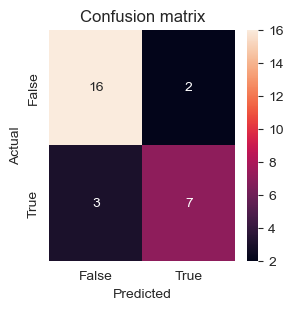

In [15]:
"""
l2 regularization
"""

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2)

positive_migration_model = LogisticRegression(max_iter=1000)
positive_migration_model.fit(X_train, Y_train > 0)

print(f"Baseline expectation: {1 - np.mean(Y_all > 0)}")
print(f"Train score: {positive_migration_model.score(X_train, Y_train > 0)}")
print(f"Test score: {positive_migration_model.score(X_test, Y_test > 0)}")

print(positive_migration_model.coef_.shape)
print(positive_migration_model.intercept_)

# show the coefficients
plt.figure(figsize=(10, 5))
plt.bar(motifs, positive_migration_model.coef_[0])
plt.title("Logistic regression coefficients: Positive migration")
plt.xticks(rotation=90)
plt.show()

y_pred = positive_migration_model.predict(X_test)

# plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(pd.crosstab(Y_test > 0, y_pred > 0), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")


# print the motifs present in the mistaken predictions

for i, (actual, pred) in enumerate(zip(Y_test > 0, y_pred > 0)):
    if actual != pred:
        print(f"{df.iloc[i]['RTK ID']}")
        print(f"Actual: {actual}, Predicted: {pred}")
        print(" ".join([motifs[j] for j in range(len(motifs)) if X_test[i, j] > 0]))
        print()

Baseline expectation: 0.8913043478260869
Train score: 0.8909090909090909
Test score: 0.8928571428571429
[-1.76355169]


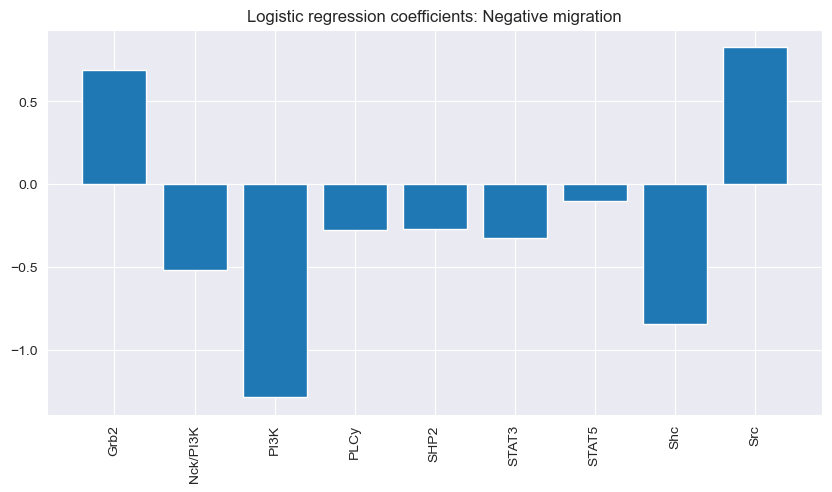

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2)

negative_migration_model = LogisticRegression(max_iter=1000)
negative_migration_model.fit(X_train, Y_train < 0)

print(f"Baseline expectation: {1 - np.mean(Y_all < 0)}")
print(f"Train score: {negative_migration_model.score(X_train, Y_train < 0)}")
print(f"Test score: {negative_migration_model.score(X_test, Y_test < 0)}")

print(negative_migration_model.intercept_)

# show the coefficients
plt.figure(figsize=(10, 5))
plt.bar(motifs, negative_migration_model.coef_[0])
plt.title("Logistic regression coefficients: Negative migration")
plt.xticks(rotation=90)
plt.show()

# run without p13k ladder
# Pi3k interaction vector
# try l1 normalization

Train score: 0.8181818181818182
Test score: 0.75
(3, 9)
[-0.58438759  1.49319176 -0.90880417]
RTK10
Actual: False, Predicted: True
PI3K Shc

RTK15
Actual: True, Predicted: False
PI3K PLCy SHP2

RTK121
Actual: False, Predicted: True
Grb2 Nck/PI3K STAT3

RTK123
Actual: False, Predicted: True
PI3K PLCy Shc

RTK127
Actual: False, Predicted: True
Nck/PI3K SHP2 Shc


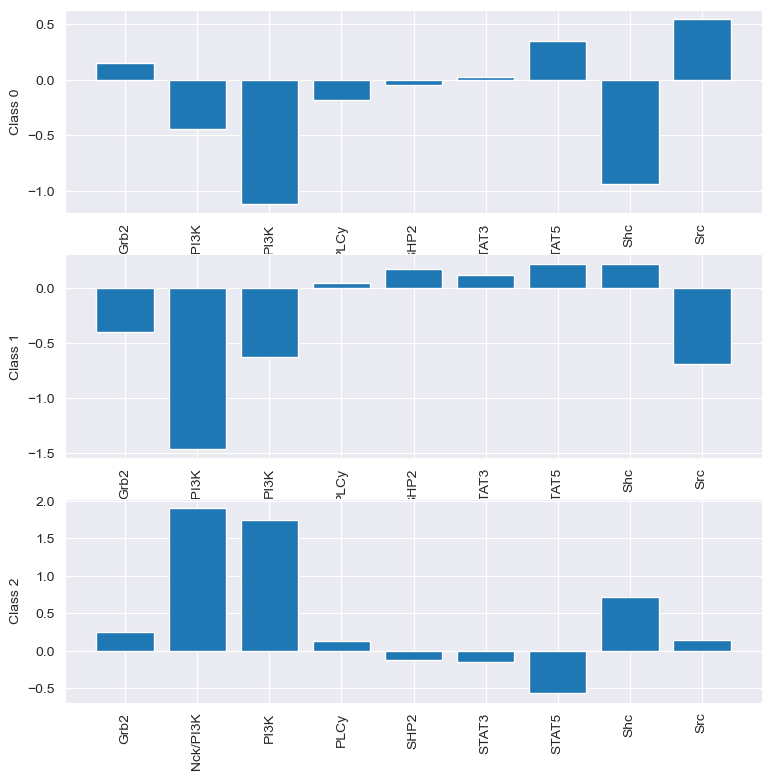

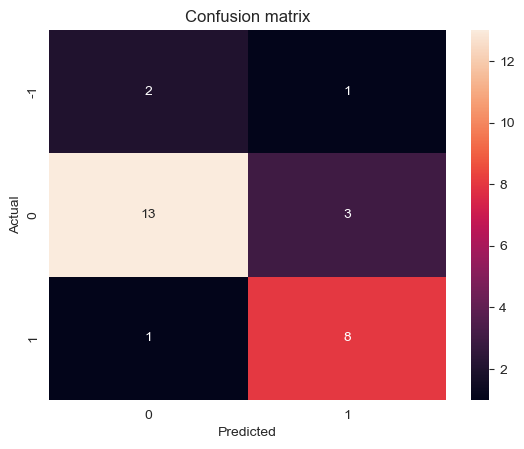

In [11]:
"""
multiclass predictions
"""
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2)

positive_migration_model = LogisticRegression(max_iter=1000)
positive_migration_model.fit(X_train, Y_train)

print(f"Train score: {positive_migration_model.score(X_train, Y_train)}")
print(f"Test score: {positive_migration_model.score(X_test, Y_test)}")

print(positive_migration_model.coef_.shape)
print(positive_migration_model.intercept_)

# show the coefficients
fig, axes = plt.subplots(3, 1, figsize=(9, 9))
for i in range(3):
    plt.sca(axes[i])
    plt.bar(motifs, positive_migration_model.coef_[i])
    # plt.title(f"Logistic regression coefficients: Positive migration, class {i}")
    plt.xticks(rotation=90)
    plt.ylabel(f"Class {i}")


# plot confusion matrix
y_pred = positive_migration_model.predict(X_test)
fig, axes = plt.subplots()
sns.heatmap(pd.crosstab(Y_test, y_pred), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")


# print the motifs present in the mistaken predictions

for i, (actual, pred) in enumerate(zip(Y_test > 0, y_pred > 0)):
    if actual != pred:
        print(f"{df.iloc[i]['RTK ID']}")
        print(f"Actual: {actual}, Predicted: {pred}")
        print(" ".join([motifs[j] for j in range(len(motifs)) if X_test[i, j] > 0]))
        print()
